In [1]:
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
import multiprocessing as mp
import scipy.sparse as sp
import itertools
import matplotlib.pyplot as plt
from gensim import corpora
from collections import defaultdict
from gensim.models import TfidfModel
from collections import Counter
import json

%matplotlib notebook

## HGNC mapper

In [31]:
hgnc = pd.read_csv('../../data/hgnc_alias_list.txt', sep='\t')
hgnc.head()

hgnc = hgnc[hgnc['Approved symbol'].apply(lambda x: 'withdrawn' not in x)]

# get the original keys
hgnc_original_keys = hgnc['Approved symbol'].unique()

# drop a lot of columns for efficiency
hgnc = hgnc[list(hgnc.columns)[0:6]].drop('Status', axis=1)

# filter out Nan synonyms (not helpful)
hgnc_syn_list = hgnc[~ hgnc.Synonyms.isna()]
hgnc_prev_symb_list = hgnc[~ hgnc['Previous symbols'].isna()]

print(hgnc_syn_list.shape)
print(hgnc_syn_list.columns)
display(hgnc_syn_list.head())

print(hgnc_prev_symb_list.shape)
print(hgnc_prev_symb_list.columns)
display(hgnc_prev_symb_list.head())

#convert the synonyms column to a list
# convert these lists to pd.Series
# merge with original dataframe
#drop old synonyms column 
# melt the new columns into rows


current_syn_list = hgnc_syn_list.Synonyms.apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(["Synonyms"], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols'], value_name = "synonym") 

current_syn_list = current_syn_list[~ current_syn_list.synonym.isna()]
current_syn_list.synonym = current_syn_list.synonym.apply(lambda x: x.replace(' ',''))


current_syn_list.head()

prev_symb_list = hgnc_prev_symb_list['Previous symbols'].apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(['Previous symbols'], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Synonyms'], value_name = "synonym") 

prev_symb_list = prev_symb_list[~ prev_symb_list.synonym.isna()]
prev_symb_list.synonym = prev_symb_list.synonym.apply(lambda x: x.replace(' ',''))


prev_symb_list.head()

hgnc_mapper = dict(zip(current_syn_list['synonym'], current_syn_list['Approved symbol']))
# add in HGNC ID mapper
hgnc_mapper.update(dict(zip(current_syn_list['HGNC ID'], current_syn_list['Approved symbol'])))
hgnc_mapper_previous = dict(zip(prev_symb_list['synonym'], prev_symb_list['Approved symbol']))

trouble_list = list(filter(lambda x: hgnc_mapper[x] != hgnc_mapper_previous[x], set(hgnc_mapper.keys())&set(hgnc_mapper_previous.keys())))

louvain_tier1 = pd.read_csv('../../results/louvain_clusters.txt', sep='\t')
for n in louvain_tier1.names:
    if (n in trouble_list):
        print(n)

hand_coded = {'RAGE':'MOK', 'SGK2':'SGK2', 'SGK196':'SGK196'}

hgnc_mapper_previous.update(hgnc_mapper) #overwrite the previous symbol conflicts

hgnc_mapper = hgnc_mapper_previous
hgnc_mapper.update({x:x for x in hgnc_original_keys}) #keep the identify maps
hgnc_mapper.update(hand_coded) # overwrite the trouble list

(21435, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
2,HGNC:24086,A1CF,APOBEC1 complementation factor,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF"
4,HGNC:7,A2M,alpha-2-macroglobulin,NaN,"FWP007, S863-7, CPAMD5"
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"


(11702, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
9,HGNC:8,A2MP1,alpha-2-macroglobulin pseudogene 1,A2MP,NaN
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"
13,HGNC:18149,A4GALT,"alpha 1,4-galactosyltransferase (P blood group)",P1,"A14GALT, Gb3S, P(k)"


RAGE


In [34]:
cluster_dir = '../../results/'

louvain_clusters =pd.read_csv(cluster_dir+'louvain_clusters.txt', sep ='\t').set_index('names')
louvain_clusters.index = pd.Series(louvain_clusters.index).apply(lambda x: hgnc_mapper[x])
display(louvain_clusters.head(5))

louvain_small_clusters =pd.read_csv(cluster_dir+'louvain_small_clusters.txt', sep ='\t').set_index('names')
louvain_small_clusters.index = pd.Series(louvain_small_clusters.index).apply(lambda x: hgnc_mapper[x])
display(louvain_small_clusters.head(5))

,cluster
names,
PAK1,5
ERBB2,5
MST1R,5
YES1,5
TYRO3,5


,cluster
names,
PAK1,3
ERBB2,18
MST1R,18
YES1,18
TYRO3,18


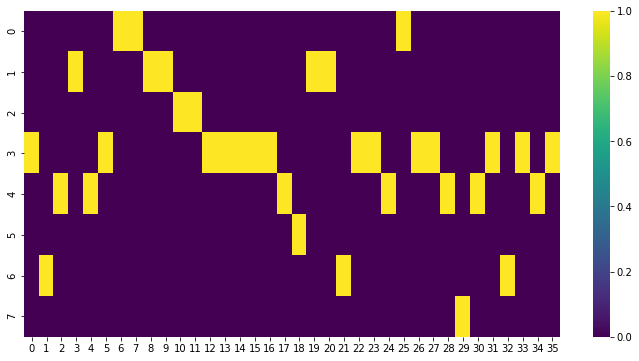

In [35]:
import seaborn as sns
from sklearn.metrics.cluster import contingency_matrix

cont_mat = pd.DataFrame(contingency_matrix(louvain_clusters, louvain_small_clusters))
#print(cont_mat.sum(axis=1))
cont_mat = cont_mat.divide(other = cont_mat.sum(axis=0),axis = 1)

fig, ax = plt.subplots(figsize=(12,6))

ann = np.copy(cont_mat)
sns.heatmap(cont_mat, ax=ax, cmap='viridis')

In [4]:
#louv_matches, spin_matches = tuple(map(list, np.where(cont_mat > 0.8)))

In [5]:
import json

In [6]:
#louv_matches = list(map(lambda x: 'supercluster_'+str(x), louv_matches))
#spin_matches = list(map(lambda x: 'subcluster_'+str(x), spin_matches))

In [36]:
parent_mapper = dict(zip(map(lambda x: 'subcluster_'+str(x), louvain_small_clusters['cluster']), map(lambda x: 'supercluster_'+str(x), louvain_clusters['cluster'])))
parent_mapper.update({x:x for x in set(map(lambda x: 'subcluster_'+str(x), list(louvain_small_clusters['cluster'].unique())))-set(parent_mapper.keys())})

In [37]:
parent_mapper

{'subcluster_3': 'supercluster_5',
 'subcluster_18': 'supercluster_5',
 'subcluster_4': 'supercluster_2',
 'subcluster_5': 'supercluster_5',
 'subcluster_6': 'supercluster_4',
 'subcluster_20': 'supercluster_2',
 'subcluster_9': 'supercluster_2',
 'subcluster_2': 'supercluster_7',
 'subcluster_12': 'supercluster_3',
 'subcluster_30': 'supercluster_8',
 'subcluster_1': 'supercluster_4',
 'subcluster_35': 'supercluster_5',
 'subcluster_10': 'supercluster_2',
 'subcluster_11': 'supercluster_3',
 'subcluster_33': 'supercluster_7',
 'subcluster_8': 'supercluster_1',
 'subcluster_24': 'supercluster_4',
 'subcluster_25': 'supercluster_5',
 'subcluster_13': 'supercluster_4',
 'subcluster_7': 'supercluster_1',
 'subcluster_26': 'supercluster_1',
 'subcluster_22': 'supercluster_7',
 'subcluster_31': 'supercluster_5',
 'subcluster_29': 'supercluster_5',
 'subcluster_27': 'supercluster_4',
 'subcluster_17': 'supercluster_4',
 'subcluster_23': 'supercluster_4',
 'subcluster_14': 'supercluster_4',
 

In [38]:
edges_df = pd.read_csv('../../data/KIN_weighted_edges.txt', sep='\t', header=None)
edges_df[0] = edges_df[0].apply(lambda x: hgnc_mapper[x])
edges_df[1] = edges_df[1].apply(lambda x: hgnc_mapper[x])
total_edges = pd.concat([edges_df[0], edges_df[1]])

edges_df.head()

,0,1,2
0,PAK1,ERBB2,3.0
1,MST1R,YES1,0.5
2,TYRO3,YES1,0.5
3,LYN,KIT,0.5
4,PRKCA,KIT,6.0


In [40]:
drug_data = pd.read_excel('../../data/Klaeger_Science_2017 Supplementary Table 6 Selectivities.xlsx', sheet_name='CATDS target')

drug_data = drug_data[drug_data.Target.isin(hgnc_mapper.keys())]

double_drug_targets = drug_data[drug_data['Target'].apply(lambda x: ';' in x)]
#double_drug_targets.shape

first_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[0])
second_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[1])

repaired_double_targets = double_drug_targets.drop('Target', axis=1).assign(**{'Target':first_genes})
repaired_double_targets = repaired_double_targets.append(double_drug_targets.drop('Target', axis=1).assign(**{'Target':second_genes})) 
#repaired_double_targets = repaired_double_targets[cols_to_keep]

drug_data = drug_data.drop(double_drug_targets.index).append(repaired_double_targets)

# convert to hgnc
drug_data.Target = drug_data.Target.apply(lambda x: hgnc_mapper[x])

# sort columns
drug_data = drug_data[['Target', 'Drug', 'At', 'CATDS']]
drug_data.head()


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


,Target,Drug,At,CATDS
0,AURKA,MK-5108,0.120921,0.657165
1,CHEK1,PF-477736,0.243725,0.733257
2,FLT3,Dovitinib,0.265240,0.860803
4,MET,Capmatinib,0.337514,1.000000
5,MAPKAPK2,VX-702,0.342705,0.743594


In [43]:
# get a list of the kinases
kin_list = list(louvain_small_clusters.index)

# define the sizes
sizes = {n:int(np.log(np.sum(drug_data.Target==n)+1)+1) for n in kin_list}
#sizes = {n:int(10) for n in louvain_small_clusters['names'].unique()}

# handy to have a kin_arr
kin_arr = np.array(kin_list)

In [44]:
sizes

{'PAK1': 1,
 'ERBB2': 1,
 'MST1R': 3,
 'YES1': 4,
 'TYRO3': 1,
 'LYN': 4,
 'KIT': 1,
 'PRKCA': 4,
 'SRC': 4,
 'MATK': 1,
 'TEC': 3,
 'FGR': 2,
 'SYK': 3,
 'PTK2': 4,
 'KDR': 1,
 'FLT1': 1,
 'ATR': 1,
 'TYK2': 3,
 'PRKCD': 4,
 'BTK': 4,
 'PRKCQ': 3,
 'PRKDC': 1,
 'PTK2B': 4,
 'PIK3CG': 1,
 'MAPK3': 2,
 'MAP4K1': 4,
 'PDGFRB': 4,
 'PIK3CA': 1,
 'PFKM': 1,
 'PFKL': 1,
 'PHKG1': 1,
 'PHKG2': 3,
 'PDGFRA': 1,
 'EIF2AK2': 1,
 'MAP3K5': 3,
 'IKBKB': 1,
 'MAPK1': 2,
 'MAP2K1': 4,
 'ARAF': 2,
 'RPS6KA2': 1,
 'MAP3K4': 3,
 'RPS6KA4': 3,
 'TRIB1': 1,
 'KSR2': 1,
 'EPHA8': 1,
 'EPHA2': 4,
 'ABL1': 5,
 'ZAP70': 1,
 'PRKCE': 1,
 'NTRK3': 1,
 'RPS6KA3': 3,
 'MAPK14': 3,
 'MAP2K2': 4,
 'RPS6KA1': 3,
 'NEK2': 1,
 'DYRK1B': 1,
 'MKNK2': 1,
 'MAPKAPK5': 2,
 'MKNK1': 1,
 'PRKCZ': 1,
 'MYLK': 2,
 'GSK3A': 4,
 'PRKCB': 3,
 'BMPR2': 3,
 'MAPK6': 1,
 'GSK3B': 4,
 'PDPK1': 1,
 'RIPK4': 1,
 'HK2': 1,
 'PIK3CB': 1,
 'PRKD1': 1,
 'AKT3': 2,
 'PRKCG': 1,
 'MARK4': 3,
 'IRAK1': 3,
 'MAP2K5': 4,
 'DAPK3': 1,
 'PKM':

In [45]:
cluster_mapper = louvain_small_clusters.to_dict()['cluster']
kin_parents = np.array([parent_mapper['subcluster_'+str(cluster_mapper[k])] for k in kin_list])
kin_children = np.array(['subcluster_'+str(cluster_mapper[k]) for k in kin_list if 'subcluster_'+str(cluster_mapper[k])])

In [46]:
parents = {par:set(kin_children[kin_parents==par].tolist()) for par in np.unique(kin_parents).tolist()}

In [47]:
# get parents plus children for parents != children
parents_plus_children = {x:{z:kin_arr[kin_children==z].tolist() for z in y if(list(y)[0] != x)} for x,y in parents.items()}

# identify parents == children
missing_parents = [x for x,y in parents_plus_children.items() if len(y)<1]
print(missing_parents)

# update to add kinases to remove parents == children
parents_plus_children = {x:y for x,y in parents_plus_children.items() if x not in missing_parents}

# place parents == children into separate dict
missing_parents = {x:kin_arr[kin_parents==x].tolist() for x in missing_parents}

# display 
parents_plus_children

[]


{'supercluster_1': {'subcluster_8': ['BMPR2',
   'BMPR1B',
   'BMPR1A',
   'ACVR2B',
   'ACVR1B',
   'ACVR1',
   'ACVR2A',
   'ACVR1C'],
  'subcluster_7': ['TGFBR2',
   'TGFBR1',
   'AMHR2',
   'ACVRL1',
   'TSSK1B',
   'DAPK2',
   'STK35',
   'CDKL1',
   'MYO3A',
   'TSSK4',
   'SGK196',
   'STK17B'],
  'subcluster_26': ['STK39', 'OXSR1', 'WNK1', 'WNK4', 'AATK', 'WNK2', 'WNK3']},
 'supercluster_2': {'subcluster_20': ['TYK2',
   'EIF2AK2',
   'JAK3',
   'JAK2',
   'JAK1'],
  'subcluster_4': ['LYN',
   'SYK',
   'FLT1',
   'PRKCD',
   'BTK',
   'PIK3CG',
   'PIK3CA',
   'PRKCZ',
   'GSK3A',
   'PRKCB',
   'GSK3B',
   'PDPK1',
   'RIPK4',
   'PIK3CB',
   'AKT3',
   'PRKCI',
   'SMG1',
   'RPS6KB1',
   'ILK',
   'SGK1',
   'PDK2',
   'PDK1',
   'SGK3',
   'RPS6KB2',
   'AKT1',
   'IGF1R',
   'FLT4',
   'PIP4K2B',
   'CSF1R',
   'AKT2',
   'TRIB3',
   'PIK3CD',
   'KHK',
   'MTOR',
   'NRBP1',
   'PIM2',
   'HK1',
   'ROR2',
   'STYK1',
   'COQ8B',
   'GRK6'],
  'subcluster_9': ['PRKCQ',
 

In [48]:
j = {"name":"viz",
     "children": [{"name": par}
                 for par in parents_plus_children.keys()]}

### Understudied

In [90]:
dark_dict = pd.read_csv('../../data/dark_kinases.csv')
dark_dict.head()

,hgnc_id,symbol,ensembl_gene_id,class,name,uniprot_ids,kinase_com_name
0,HGNC:19038,ADCK1,ENSG00000063761,Dark,aarF domain containing kinase 1,Q86TW2,ADCK1
1,HGNC:19039,ADCK2,ENSG00000133597,Dark,aarF domain containing kinase 2,Q7Z695,ADCK2
2,HGNC:21738,ADCK5,ENSG00000173137,Dark,aarF domain containing kinase 5,Q3MIX3,ADCK5
3,HGNC:20565,ALPK2,ENSG00000198796,Dark,alpha kinase 2,Q86TB3,AlphaK2
4,HGNC:17574,ALPK3,ENSG00000136383,Dark,alpha kinase 3,Q96L96,AlphaK1


In [87]:
dark_dict = dict(zip(dark_dict.symbol.apply(lambda x: hgnc_mapper[x]), ['dark']*len(dark_dict)))
len(dark_dict)
dark_dict.update({x:'well' for x in list(set([hgnc_mapper[x] for x in kin_list])-set(dark_dict.keys()))})
print(len(dark_dict))
#dark_dict

526


### Json Creation

In [49]:
# first get the kinases of depth 3
json_out = {"name":"viz",
            "children":[
                {"name":str(parent), 
                "children":[
                    {"name":str(child), 
                    "children":[
                        {"name":str(k),
                        "size":int(sizes[k])}
                        "studied":dark_dict[k]
                        for k in kinases]}
                     for child, kinases in children.items()]} 
                for parent, children in parents_plus_children.items()]}

# extra json
missing_json = [
    {"name":str(parent),
    "children":[
        {"name":str(k),
        "size":int(sizes[k])}
        for k in kinases]}
    for parent, kinases in missing_parents.items()]

json_out["children"] = json_out["children"] + missing_json

In [50]:
# str_out is a JSON-formatted string from the json_out dictionary
# the 'replace' steps make the file more human-readable for debugging, etc
str_out = json.dumps(json_out).replace("},", "}, \n").replace('[{', '[\n{\n').replace(']},', ']}\n,\n')

In [51]:
with open('dist/viz.json', 'w') as f:
    f.write(str_out)